## Thin plate spline

Find an interpolating surface to a set of control points with minimum bend. For image interpolation consider two such surfaces, one for each principal axis.

### References
[1] Donato, G., & Belongie, S. J. (2003). Approximation methods for thin plate spline mappings and principal warps. Department of Computer Science and Engineering, University of California, San Diego.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import thinplate as tps

### Fit surface through control points

<a list of 7 text.Text objects>

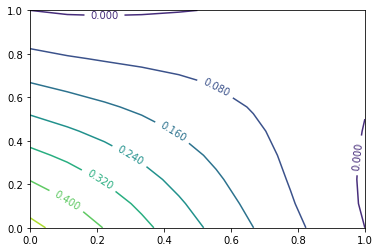

In [3]:
# Points the surface should pass through
c = np.array([
    [0., 0, 0.5],
    [1., 0, 0.0],
    [1., 1, 0.0],
    [0, 1, 0.0],
])

theta = tps.TPS.fit(c)
grid = tps.uniform_grid((10,10))
Z = tps.TPS.z(grid.reshape((-1,2)), c, theta).reshape(10, 10)

fig, ax = plt.subplots()
c = ax.contour(grid[...,0], grid[...,1], Z)
ax.clabel(c, inline=1, fontsize=10)

#### Fit surface through control points in reduced form

One less parameter as the `sum(w) = 0`.

<a list of 7 text.Text objects>

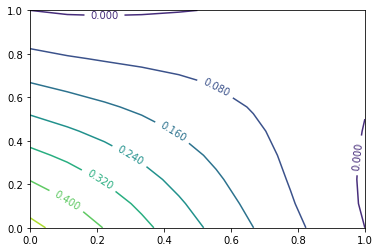

In [4]:
c = np.array([
    [0., 0, 0.5],
    [1., 0, 0.0],
    [1., 1, 0.0],
    [0, 1, 0.0],
])

theta = tps.TPS.fit(c, reduced=True)
grid = tps.uniform_grid((10,10))
Z = tps.TPS.z(grid.reshape((-1,2)), c, theta).reshape(10, 10)

fig, ax = plt.subplots()
c = ax.contour(grid[...,0], grid[...,1], Z)
ax.clabel(c, inline=1, fontsize=10)

### Image interpolation
For image interpolation, we define a separate surface for x and y offsets.

In [6]:
def show_warped(img, warped):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].imshow(img[...,::-1], origin='upper')
    axs[0].scatter(c_src[:, 0]*img.shape[1], c_src[:, 1]*img.shape[0], marker='+', color='black')
    axs[1].imshow(warped[...,::-1], origin='upper')
    axs[1].scatter(c_dst[:, 0]*warped.shape[1], c_dst[:, 1]*warped.shape[0], marker='+', color='black')
    plt.show()

In [8]:
def warp_image_cv(img, c_src, c_dst, dshape=None):
    dshape = dshape or img.shape
    theta = tps.tps_theta_from_points(c_src, c_dst, reduced=True)
    grid = tps.tps_grid(theta, c_dst, dshape)
    mapx, mapy = tps.tps_grid_to_remap(grid, img.shape)
    return cv2.remap(img, mapx, mapy, cv2.INTER_CUBIC , borderValue=(255,255,255))

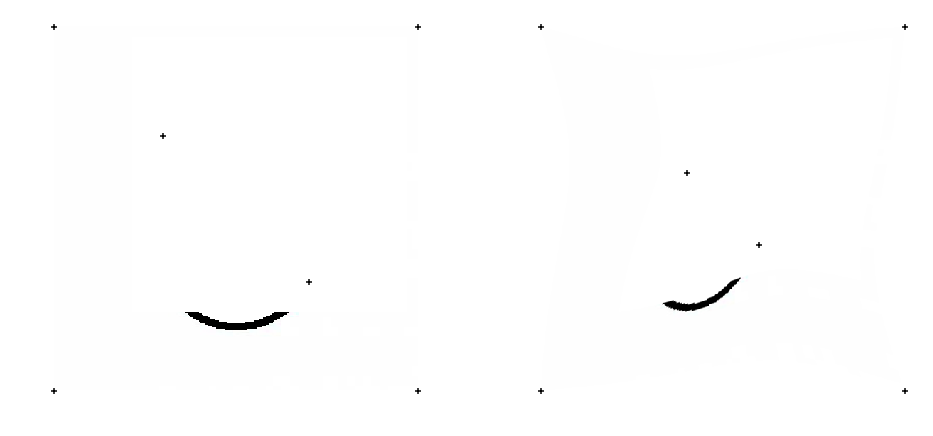

In [9]:
import cv2
img = cv2.imread('../../../data/autocomplete-outlines-test-restricted/scribbles/basketball/38_192_0.png')

c_src = np.array([
    [0.0, 0.0],
    [1., 0],
    [1, 1],
    [0, 1],
    [0.3, 0.3],
    [0.7, 0.7],
])

c_dst = np.array([
    [0., 0],
    [1., 0],    
    [1, 1],
    [0, 1],
    [0.4, 0.4],
    [0.6, 0.6],
])
    
warped = warp_image_cv(img, c_src, c_dst, dshape=(512, 512))
show_warped(img, warped)

### Iterative optimization of theta

In [8]:
def to_numpy_image(x):
    return (x.detach().permute(0,2,3,1).numpy()*255).astype(np.uint8)

0 0.3812499940395355
20 0.3106635808944702
40 0.16054204106330872
60 0.13597464561462402
80 0.11782476305961609
100 0.07986719161272049
120 0.06436777114868164
140 0.054589271545410156
160 0.03617062419652939
180 0.023204216733574867
200 0.02091282606124878
220 0.02024226263165474
240 0.019653908908367157
260 0.019123008474707603
280 0.018624253571033478
300 0.018349742516875267
320 0.017725571990013123
340 0.01730738766491413
360 0.016924910247325897
380 0.016554774716496468


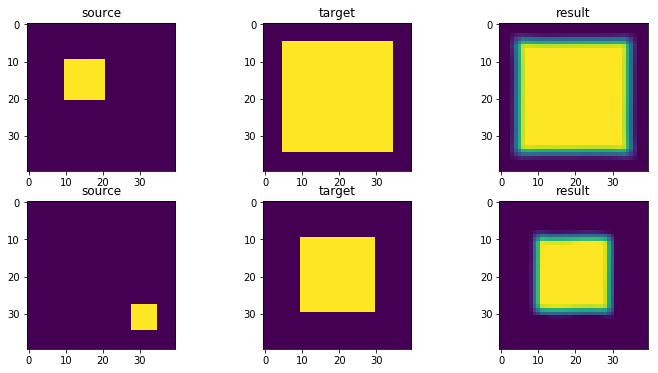

In [9]:
import torch
import torch.optim as optim
import torch.nn.functional as F

src = torch.zeros(2, 1, 40, 40)
src[0,..., 10:21, 10:21] = 1
src[1,..., 28:35, 28:35] = 1

target = torch.zeros_like(src)
target[0, ..., 5:-5, 5:-5] = 1
target[1, ..., 10:-10, 10:-10] = 1

c_dst = tps.torch.uniform_grid((2,2)).view(-1, 2)
theta = torch.zeros(src.shape[0], (c_dst.shape[0]+2), 2, requires_grad=True)
size = src.shape
opt = optim.Adam([theta], lr=1e-2)

for i in range(400):
    opt.zero_grad()
    
    grid = tps.torch.tps_grid(theta, torch.tensor(c_dst), size)
    warped = F.grid_sample(src, grid)

    loss = F.mse_loss(warped, target)
    loss.backward()
    opt.step()
    
    if i % 20 == 0:
        print(i, loss.item())
        
src_np = to_numpy_image(src).squeeze()
dst_np = to_numpy_image(target).squeeze()
final_np = to_numpy_image(warped).squeeze()

fig, axs = plt.subplots(src.shape[0], 3, figsize=(12,6))
for i in range(src.shape[0]):
    axs[i,0].imshow(src_np[i])
    axs[i,1].imshow(dst_np[i])
    axs[i,2].imshow(final_np[i])
    axs[i,0].set_title('source')
    axs[i,1].set_title('target')
    axs[i,2].set_title('result')

### Supervised learning of theta

In [111]:
class RandomRectangleDataset:
    def __init__(self, n=1000, shape=(1,40,40)):
        self.n = n
        self.shape = shape        
        self.target = torch.zeros(shape)
        self.target[:, 5:-5, 5:-5] = torch.linspace(0.5, 1.0, shape[1]-10).view(1, shape[1]-10, 1)
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        x = torch.randint(0, self.shape[2]-10, (1,)).to(torch.int).item()
        y = torch.randint(0, self.shape[1]-10, (1,)).to(torch.int).item()
        h = torch.randint(2, self.shape[1] - y, (1,)).to(torch.int).item()
        w = torch.randint(2, self.shape[2] - x, (1,)).to(torch.int).item()
        
        img = torch.zeros(self.shape)
        img[:, y:y+h, x:x+h] = torch.linspace(0.5, 1.0, h).view(1, h, 1)
        
        return img, self.target

In [112]:
class Model(torch.nn.Module):
    def __init__(self, outshape, ctrlshape=(6,6)):
        super().__init__()
        self.nctrl = ctrlshape[0]*ctrlshape[1]
        self.outshape = outshape
        self.nparam = (self.nctrl + 2)
        ctrl = tps.torch.uniform_grid(ctrlshape)
        self.register_buffer('ctrl', ctrl.view(-1,2))
        
        self.f = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.AdaptiveMaxPool2d((5,5))
        )
        
        self.loc = torch.nn.Sequential(
            torch.nn.Linear(25*128, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, self.nparam*2),
            torch.nn.Tanh()
        )        
        
        self.loc[-2].weight.data.normal_(0, 1e-3)
        self.loc[-2].bias.data.zero_()
        
    def forward(self, x):
        xs = self.f(x)
        theta = self.loc(xs.view(x.shape[0], -1)).view(-1, self.nparam, 2)
        grid = tps.torch.tps_grid(theta, self.ctrl, (x.shape[0], ) + self.outshape)
        return F.grid_sample(x, grid), theta                   

In [113]:
import torch.utils.data as data

imgshape = (1,40,40)
ds_train = RandomRectangleDataset(shape=imgshape)
ds_test = RandomRectangleDataset(n=100, shape=imgshape)

dl_train = data.DataLoader(ds_train, batch_size=32, shuffle=False)
dl_test = data.DataLoader(ds_test, batch_size=32, shuffle=False)

In [114]:
def train(net, dev, dl_train, dl_test, nepochs=5, lr=1e-3):
    net.train()
    
    opt = optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(nepochs):
        net.train()
        train_loss = 0.
        for x,y in dl_train:        
            opt.zero_grad()
                
            x = x.to(dev)
            y = y.to(dev)
            w,theta = net(x)
            
            loss = F.mse_loss(w, y)
            loss.backward()
            opt.step()  
            
            train_loss += loss.item()
        
        net.eval()
        test_loss = 0.
        with torch.no_grad():
            for x,y in dl_test:
                x = x.to(dev)
                y = y.to(dev)
                w,theta = net(x)
                loss = F.mse_loss(w, y)
                test_loss += loss.item()
                
        if (epoch % 10 == 0):
            print(epoch, train_loss/len(dl_train), test_loss/len(dl_test))
                

In [115]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Model(imgshape, (4,4)).to(dev)
train(net, dev, dl_train, dl_test, nepochs=40, lr=1e-4)

0 0.25673609087243676 0.27082938328385353
10 0.05939108564052731 0.05904558394104242
20 0.03884411102626473 0.0439998097717762
30 0.03105964878341183 0.027322665322571993


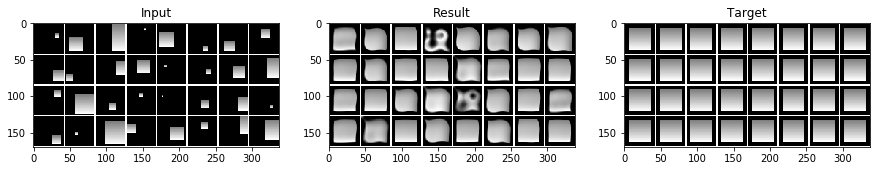

In [116]:
from torchvision.utils import make_grid

x,y = next(iter(dl_test))
with torch.no_grad():
    xx, theta = net(x.to(dev))

gx = make_grid(x, padding=2, pad_value=1)
gxx = make_grid(xx, padding=2, pad_value=1)
gy = make_grid(y, padding=2, pad_value=1)

fig, axs = plt.subplots(1, 3, figsize=(15,10))
axs[0].imshow(gx.permute(1,2,0).numpy())
axs[0].set_title('Input')
axs[1].imshow(gxx.cpu().permute(1,2,0).numpy())
axs[1].set_title('Result')
axs[2].imshow(gy.permute(1,2,0).numpy())
axs[2].set_title('Target')
plt.show()

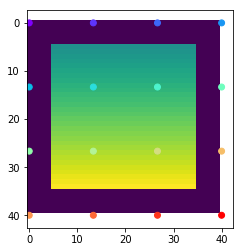

In [117]:
# Target
import matplotlib.cm as cm

H,W = xx.shape[-2:]
scale = xx.new_tensor([W,H])
colors = cm.rainbow(np.linspace(0, 1, net.ctrl.shape[0]))

xy_dst = net.ctrl * scale.view(1,-1)
plt.imshow(y[0][0])
plt.scatter(xy_dst[:, 0], xy_dst[:, 1], c=colors)

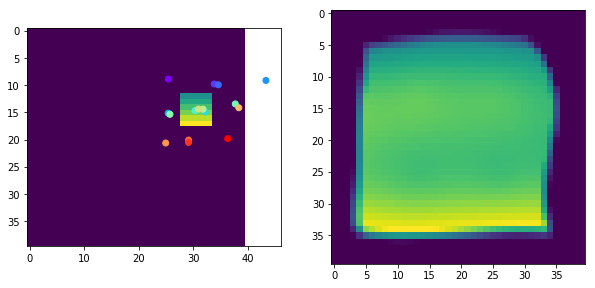

In [119]:

xy_src = tps.torch.tps_sparse(theta, net.ctrl, net.ctrl) * scale.view(1,1,-1)

i=0
fix, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(x[i][0])
ax[0].scatter(xy_src[i, :, 0], xy_src[i, :, 1], c=colors)

ax[1].imshow(xx[i][0])